### 1.a.

In [278]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os

In [279]:
df_raw = pd.read_csv("New York City Taxi Trip Duration .csv")
df_raw.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


### 1.b.

In [280]:
df = df_raw.drop(axis=1, columns=['vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag'])
df.head()

,id,pickup_longitude,pickup_latitude,trip_duration
0,id2875421,-73.982155,40.767937,455
1,id2377394,-73.980415,40.738564,663
2,id3858529,-73.979027,40.763939,2124
3,id3504673,-74.010040,40.719971,429
4,id2181028,-73.973053,40.793209,435


### 1.c.

In [281]:
df['pickup_longitude'] = (df['pickup_longitude'] - df['pickup_longitude'].min()) / (df['pickup_longitude'].max() - df['pickup_longitude'].min())
df['pickup_latitude'] = (df['pickup_latitude'] - df['pickup_latitude'].min()) / (df['pickup_latitude'].max() - df['pickup_latitude'].min())
df.head()

,id,pickup_longitude,pickup_latitude,trip_duration
0,id2875421,0.525209,0.650127,455
1,id2377394,0.529221,0.527039,663
2,id3858529,0.532424,0.633374,2124
3,id3504673,0.460889,0.449126,429
4,id2181028,0.546203,0.756031,435


In [282]:
X = df[['pickup_longitude', 'pickup_latitude']].values

### 1.d.

In [283]:
PLOTSDIR = 'plots/'

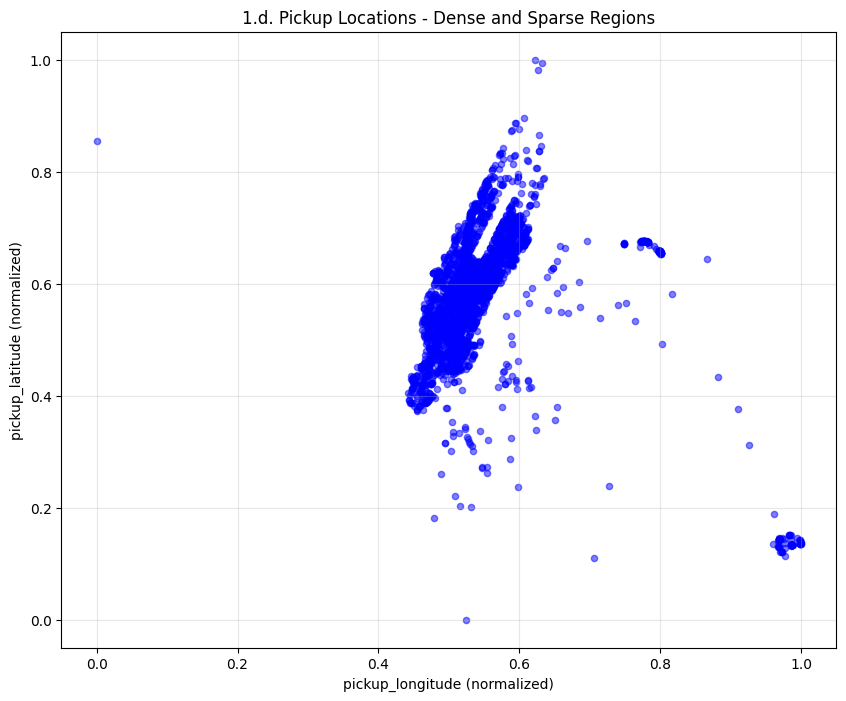

In [284]:
plt.figure(figsize=(10, 8))
plt.scatter(df['pickup_longitude'], df['pickup_latitude'], alpha=0.5, s=20, color='blue')
plt.xlabel('pickup_longitude (normalized)')
plt.ylabel('pickup_latitude (normalized)')
plt.title('1.d. Pickup Locations - Dense and Sparse Regions')
plt.grid(True, alpha=0.3)
plt.savefig(PLOTSDIR + '1d_pickup_scatter.png', dpi=100, bbox_inches='tight')
plt.show()

### 1.e.

In [285]:
def distance(point1, point2):
    return np.sum((point1 - point2)**2)

In [286]:
def get_neighbors(X, point_index, eps_squared):
    """
    Finds all points in X that are within eps (using eps_squared) of the
    point at point_index.
    
    Args:
        X (np.array): The input data (n_samples, n_features).
        point_index (int): The index of the point to find neighbors for.
        eps_squared (float): The squared epsilon (radius) for the neighborhood.

    Returns:
        list: A list of indices of the neighboring points (including the
              point itself, as min_pts includes the point).
    """
    center_point = X[point_index]
    # Vectorized distance computation: much faster than loop
    distances_squared = np.sum((X - center_point)**2, axis=1)
    # Return indices where distance <= eps_squared
    return np.where(distances_squared <= eps_squared)[0].tolist()

In [287]:
def expand_cluster(X, labels, point_index, cluster_id, eps_squared, min_pts, neighbors_of_start_point):
    """
    Expands a cluster from a starting core point.
    This function modifies the 'labels' array in-place.
    
    Args:
        X (np.array): The input data (n_samples, n_features).
        labels (np.array): Array of labels for each point (-2=Unclassified, -1=Noise, >=0=Cluster ID).
        point_index (int): The index of the core point to start expansion from.
        cluster_id (int): The new cluster ID to assign.
        eps_squared (float): The squared epsilon (radius) for the neighborhood.
        min_pts (int): The minimum number of points to form a dense region.
        neighbors_of_start_point (list): The pre-computed neighbors of the starting point.
    """
    
    labels[point_index] = cluster_id
    queue = neighbors_of_start_point[:]
    queue_set = set(queue)  # For O(1) membership checking
    
    i = 0
    while i < len(queue):
        current_idx = queue[i]
        
        if labels[current_idx] == -1:
            labels[current_idx] = cluster_id
        elif labels[current_idx] == -2:
            labels[current_idx] = cluster_id
            neighbors_of_current = get_neighbors(X, current_idx, eps_squared)
            
            if len(neighbors_of_current) >= min_pts:
                for idx in neighbors_of_current:
                    if labels[idx] in [-1, -2] and idx not in queue_set:
                        queue.append(idx)
                        queue_set.add(idx)
        
        i += 1

In [288]:
def dbscan_model(X, eps, min_pts):
    """
    Performs DBSCAN clustering on the dataset X.
    
    Args:
        X (pd.DataFrame or np.array): The input data (n_samples, n_features).
                                      'y' is not used (unsupervised).
        eps (float): The maximum distance between two samples for one to be
                     considered as in the neighborhood of the other (hyperparameter).
        min_pts (int): The number of samples (or total weight) in a neighborhood
                       for a point to be considered as a core point (hyperparameter).
                       This includes the point itself.

    Returns:
        np.array: An array of cluster labels for each point.
                  Noise points are labeled -1.
                  Clusters are labeled 0, 1, 2, ...
    """
    print(f'dbscan_model {min_pts} {eps}')
    if isinstance(X, pd.DataFrame):
        X_np = X.values
    elif isinstance(X, np.ndarray):
        X_np = X
    else:
        raise TypeError("Input X must be a pandas DataFrame or a numpy array.")
    
    n_samples = X_np.shape[0]
    eps_squared = eps**2
    labels = np.full(n_samples, -2, dtype=int)
    cluster_id = 0
    
    for i in range(n_samples):
        if i % 1000 == 0:
            print(f"Processing point {i}/{n_samples}")
        
        if labels[i] != -2:
            continue
        
        neighbors = get_neighbors(X_np, i, eps_squared)
        
        if len(neighbors) < min_pts:
            labels[i] = -1
            continue
        
        expand_cluster(
            X=X_np,
            labels=labels,
            point_index=i,
            cluster_id=cluster_id,
            eps_squared=eps_squared,
            min_pts=min_pts,
            neighbors_of_start_point=neighbors
        )
        cluster_id += 1
    
    return labels

In [289]:
def compute_k_distances_manual(X, k):
    """
    Compute k-distances for all points without sklearn.
    Returns sorted k-distances for k-distance graph.
    """
    n_samples = X.shape[0]
    k_distances = np.zeros(n_samples)
    
    # Compute all pairwise distances at once using broadcasting
    for i in range(n_samples):
        if i % 1000 == 0:
            print(f"Computing k-distances: {i}/{n_samples}")
        
        # Vectorized distance computation
        distances = np.sqrt(np.sum((X - X[i])**2, axis=1))
        # Sort and get k-th distance
        k_distances[i] = np.partition(distances, k)[k]
    
    return np.sort(k_distances)


on 5
on 0.001
dbscan_model 5 0.001
Processing point 0/2999
Processing point 1000/2999
Processing point 2000/2999
on 0.002
dbscan_model 5 0.002
Processing point 0/2999
Processing point 1000/2999
Processing point 2000/2999
on 0.003
dbscan_model 5 0.003
Processing point 0/2999
Processing point 1000/2999
Processing point 2000/2999
on 0.004
dbscan_model 5 0.004
Processing point 0/2999
Processing point 1000/2999
Processing point 2000/2999
on 0.005
dbscan_model 5 0.005
Processing point 0/2999
Processing point 1000/2999
Processing point 2000/2999
on 0.006
dbscan_model 5 0.006
Processing point 0/2999
Processing point 1000/2999
Processing point 2000/2999
on 0.007
dbscan_model 5 0.007
Processing point 0/2999
Processing point 1000/2999
Processing point 2000/2999
on 0.008
dbscan_model 5 0.008
Processing point 0/2999
Processing point 1000/2999
Processing point 2000/2999
on 0.009000000000000001
dbscan_model 5 0.009000000000000001
Processing point 0/2999
Processing point 1000/2999
Processing point 200

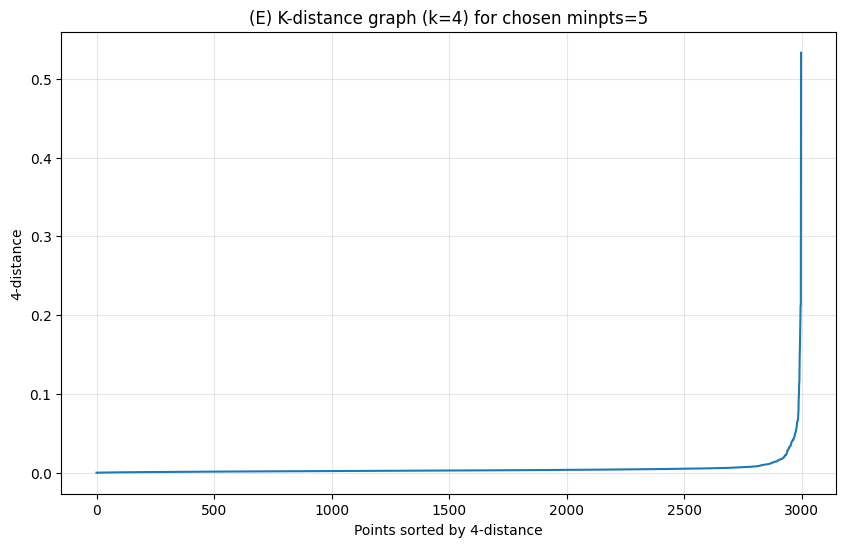

Detected eps from knee detection: 0.008804 (at index 2822)


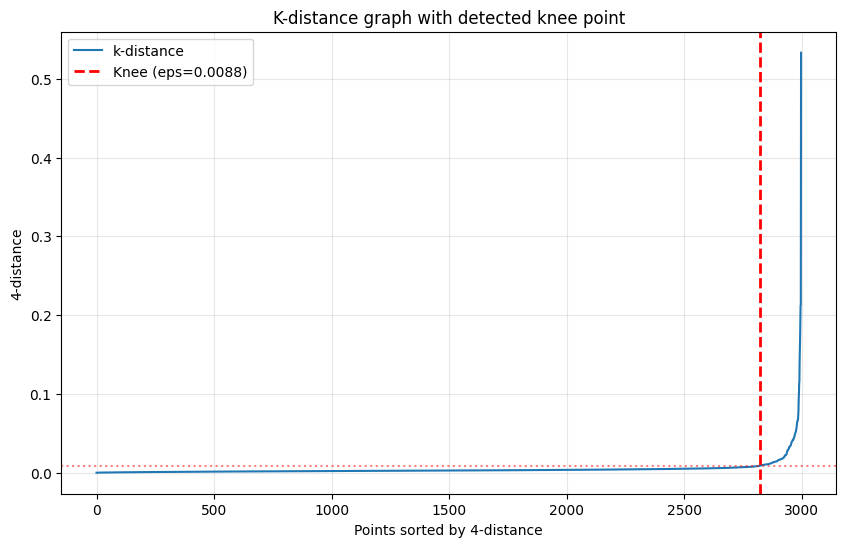


dbscan_model 5 0.008804327263136132
Processing point 0/2999
Processing point 1000/2999
Processing point 2000/2999
Number of clusters found: 10
Cluster distribution: (array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9]), array([ 152, 2682,   37,   26,   15,   38,   16,    6,   18,    4,    5]))



C:\Users\Vemor\AppData\Local\Temp\ipykernel_760\2489238945.py:84: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', max(n_clusters, 1))


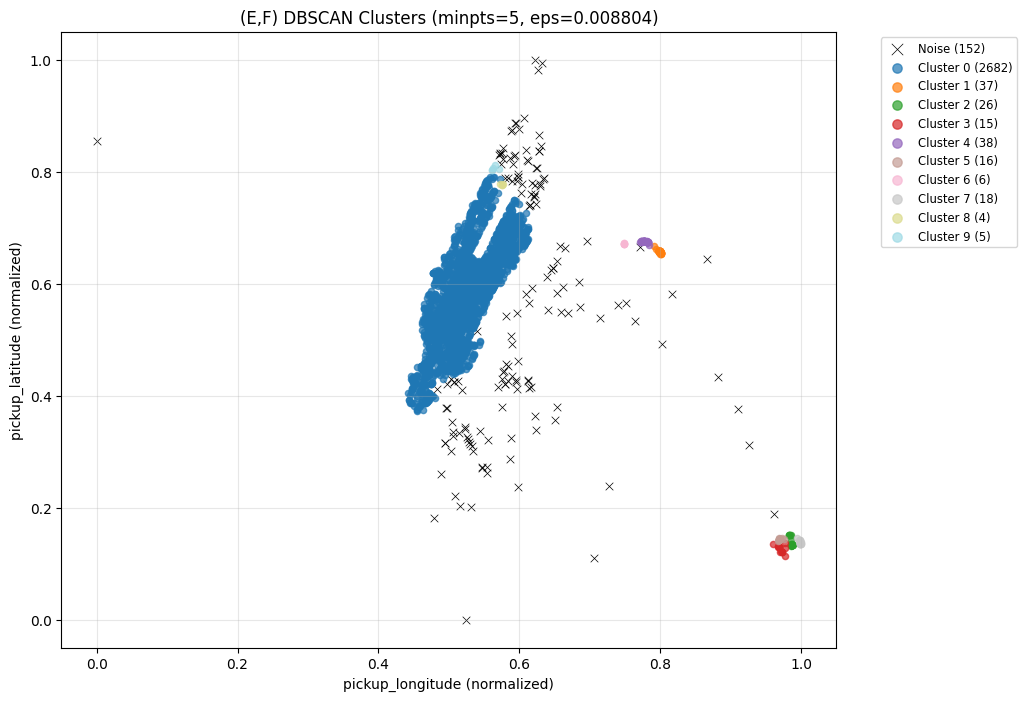

In [290]:
minpts_list = [5, 10, 15]
eps_candidates = np.linspace(0.001, 0.05, 50)

results = {}
for minpts in minpts_list:
    print(f'on {minpts}')
    best_max_cluster = 0
    best_eps_for_minpts = None
    best_labels = None

    for eps in eps_candidates:
        print(f'on {eps}')
        labels = dbscan_model(X, eps=eps, min_pts=minpts)
        unique, counts = np.unique(labels[labels >= 0], return_counts=True) if np.any(labels >= 0) else (np.array([]), np.array([]))
        max_cluster_size = counts.max() if counts.size > 0 else 0

        if max_cluster_size > best_max_cluster:
            best_max_cluster = max_cluster_size
            best_eps_for_minpts = eps
            best_labels = labels.copy()

    results[minpts] = {
        'best_eps': best_eps_for_minpts,
        'best_max_cluster': best_max_cluster,
        'labels': best_labels
    }

chosen_minpts = max(results.keys(), key=lambda k: results[k]['best_max_cluster'])
print(f"Chosen minpts: {chosen_minpts}")
print(f"Best max cluster size: {results[chosen_minpts]['best_max_cluster']}")
print(f"Eps from initial sweep: {results[chosen_minpts]['best_eps']:.6f}")
print()

k = chosen_minpts - 1
print(f"Computing k-distance graph for k={k}...")
k_distances = compute_k_distances_manual(X, k)

plt.figure(figsize=(10, 6))
plt.plot(k_distances, linewidth=1.5)
plt.xlabel(f'Points sorted by {k}-distance')
plt.ylabel(f'{k}-distance')
plt.title(f'(E) K-distance graph (k={k}) for chosen minpts={chosen_minpts}')
plt.grid(True, alpha=0.3)
plt.savefig(PLOTSDIR + f'1e_k_distance_minpts_{chosen_minpts}.png', dpi=100, bbox_inches='tight')
plt.show()

n_points = len(k_distances)
start_idx = int(0.3 * n_points)
end_idx = int(0.95 * n_points)

grad1 = np.gradient(k_distances[start_idx:end_idx])
grad2 = np.gradient(grad1)

percentile_90 = int(0.6 * len(grad2))
knee_idx_local = start_idx + percentile_90 + np.argmax(np.abs(grad2[percentile_90:]))
knee_idx = knee_idx_local

eps_from_knee = k_distances[knee_idx]
print(f"Detected eps from knee detection: {eps_from_knee:.6f} (at index {knee_idx})")

plt.figure(figsize=(10, 6))
plt.plot(k_distances, linewidth=1.5, label='k-distance')
plt.axvline(x=knee_idx, color='r', linestyle='--', linewidth=2, label=f'Knee (eps={eps_from_knee:.4f})')
plt.axhline(y=eps_from_knee, color='r', linestyle=':', alpha=0.5)
plt.xlabel(f'Points sorted by {k}-distance')
plt.ylabel(f'{k}-distance')
plt.title(f'K-distance graph with detected knee point')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(PLOTSDIR + f'1e_k_distance_knee_{chosen_minpts}.png', dpi=100, bbox_inches='tight')
plt.show()
print()

final_labels = dbscan_model(X, eps=eps_from_knee, min_pts=chosen_minpts)

unique_labels = np.unique(final_labels)
n_clusters = len(unique_labels[unique_labels >= 0])
n_noise = np.sum(final_labels == -1)

print(f"Number of clusters found: {n_clusters}")
print(f"Cluster distribution: {np.unique(final_labels, return_counts=True)}")
print()

colors = plt.cm.get_cmap('tab20', max(n_clusters, 1))
plt.figure(figsize=(10, 8))
for lbl in unique_labels:
    mask = final_labels == lbl
    if lbl == -1:
        plt.scatter(X[mask, 0], X[mask, 1], c='k', marker='x', s=30, linewidths=0.5, label=f'Noise ({n_noise})')
    else:
        cluster_size = np.sum(mask)
        plt.scatter(X[mask, 0], X[mask, 1], color=colors(lbl % 20), s=20, alpha=0.7, label=f'Cluster {lbl} ({cluster_size})')

plt.legend(markerscale=1.5, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.xlabel('pickup_longitude (normalized)')
plt.ylabel('pickup_latitude (normalized)')
plt.title(f'(E,F) DBSCAN Clusters (minpts={chosen_minpts}, eps={eps_from_knee:.6f})')
plt.grid(True, alpha=0.3)
plt.savefig(PLOTSDIR + f'1ef_dbscan_clusters_minpts_{chosen_minpts}.png', dpi=100, bbox_inches='tight')
plt.show()

### 1.f.

In [291]:
if np.any(final_labels >= 0):
    uniq, cnts = np.unique(final_labels[final_labels >= 0], return_counts=True)
    cluster_info = sorted(zip(uniq, cnts), key=lambda x: x[1], reverse=True)
    
    print(f"Total clusters found: {len(cluster_info)}")
    print(f"Total noise points: {n_noise}")
    print()
    print("Cluster Details (sorted by size):")
    print("-" * 100)
    print(f"{'Cluster':<10} {'Size':<10} {'Centroid (lon, lat)':<35} {'Avg Trip Duration (s)':<25}")
    print("-" * 100)
    
    for lab, size in cluster_info:
        # Get points in this cluster
        mask = final_labels == lab
        pts = X[mask]
        centroid = pts.mean(axis=0)
        
        # Get average trip duration for this cluster
        indices_in_cluster = np.where(mask)[0]
        trip_durations = df.iloc[indices_in_cluster]['trip_duration'].values
        avg_trip_duration = trip_durations.mean()
        
        print(f"{lab:<10} {size:<10} ({centroid[0]:.4f}, {centroid[1]:.4f}){'':<15} {avg_trip_duration:<25.2f}")
    
    print("-" * 100)
    largest_label = cluster_info[0][0]
    print(f"\nRegion with maximum pickups: Cluster {largest_label}, Size: {cluster_info[0][1]}")
    print()
else:
    print("No clusters found with the detected eps/minpts combination.")
    print()


Total clusters found: 10
Total noise points: 152

Cluster Details (sorted by size):
----------------------------------------------------------------------------------------------------
Cluster    Size       Centroid (lon, lat)                 Avg Trip Duration (s)    
----------------------------------------------------------------------------------------------------
0          2682       (0.5254, 0.5883)                859.18                   
4          38         (0.7785, 0.6751)                1925.29                  
1          37         (0.7990, 0.6571)                1781.73                  
2          26         (0.9860, 0.1371)                2088.73                  
7          18         (0.9985, 0.1375)                2239.94                  
5          16         (0.9694, 0.1432)                1815.94                  
3          15         (0.9708, 0.1262)                2095.13                  
6          6          (0.7487, 0.6712)                2171.50         

### 1.g.

Total noise points (outliers): 152
Total points: 2999
Noise percentage: 5.07%



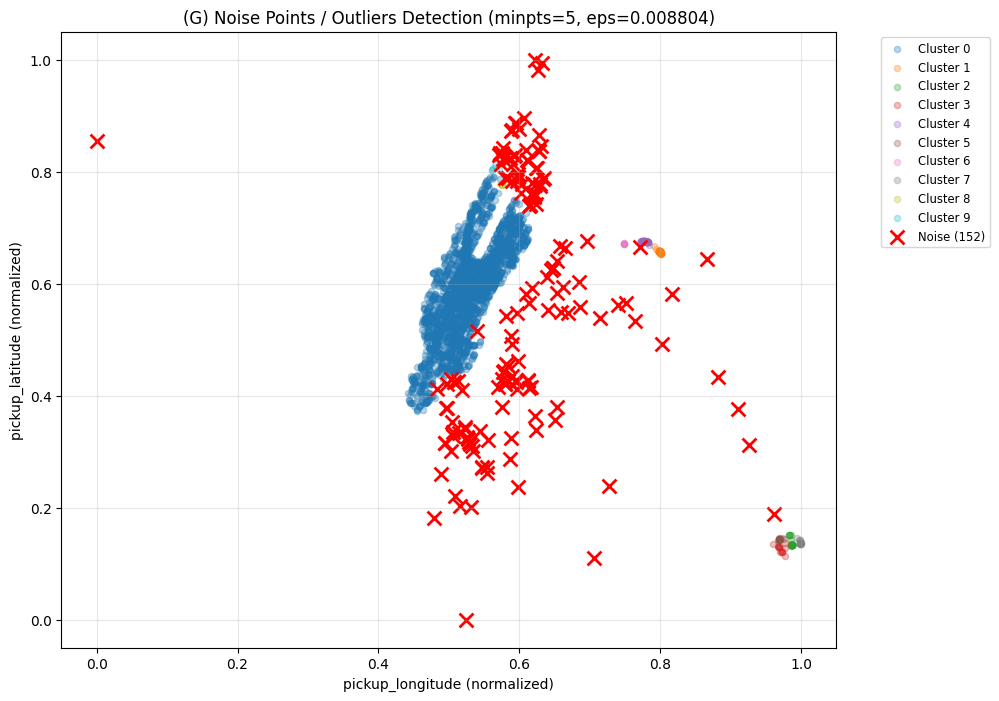

Noise Points Statistics:
  Average trip duration (noise): 786.39 seconds
  Min trip duration (noise): 2.00 seconds
  Max trip duration (noise): 4322.00 seconds
  Std dev (noise): 646.51 seconds



In [292]:
noise_mask = final_labels == -1
noise_count = np.sum(noise_mask)
total_points = len(final_labels)
noise_percentage = (noise_count / total_points) * 100

print(f"Total noise points (outliers): {noise_count}")
print(f"Total points: {total_points}")
print(f"Noise percentage: {noise_percentage:.2f}%")
print()

# Plot noise points separately
if noise_count > 0:
    plt.figure(figsize=(10, 8))
    
    # Plot all clusters
    for lbl in np.unique(final_labels[final_labels >= 0]):
        mask = final_labels == lbl
        plt.scatter(X[mask, 0], X[mask, 1], s=20, alpha=0.3, label=f'Cluster {lbl}')
    
    # Highlight noise points
    noise_pts = X[noise_mask]
    plt.scatter(noise_pts[:, 0], noise_pts[:, 1], c='red', marker='x', s=100, linewidths=2, label=f'Noise ({noise_count})')
    
    plt.xlabel('pickup_longitude (normalized)')
    plt.ylabel('pickup_latitude (normalized)')
    plt.title(f'(G) Noise Points / Outliers Detection (minpts={chosen_minpts}, eps={eps_from_knee:.6f})')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    plt.grid(True, alpha=0.3)
    plt.savefig(PLOTSDIR + '1g_noise_points.png', dpi=100, bbox_inches='tight')
    plt.show()
    
    # Statistics for noise points
    noise_indices = np.where(noise_mask)[0]
    noise_trip_durations = df.iloc[noise_indices]['trip_duration'].values
    
    print("Noise Points Statistics:")
    print(f"  Average trip duration (noise): {noise_trip_durations.mean():.2f} seconds")
    print(f"  Min trip duration (noise): {noise_trip_durations.min():.2f} seconds")
    print(f"  Max trip duration (noise): {noise_trip_durations.max():.2f} seconds")
    print(f"  Std dev (noise): {noise_trip_durations.std():.2f} seconds")
    print()


### 1.h.

In analysis_1.md

### 1.i.

Computing Silhouette scores for 2847 points...
  Progress: 0/2847
  Progress: 500/2847
  Progress: 1000/2847
  Progress: 1500/2847
  Progress: 2000/2847
  Progress: 2500/2847

Silhouette Score Analysis:
--------------------------------------------------------------------------------
Average Silhouette Score: 0.3764
Min Silhouette Score: -0.9525
Max Silhouette Score: 0.9832
Std Dev: 0.3952

Interpretation:
Cluster Quality: Fair
Meaning: Weak cluster structure, significant overlap


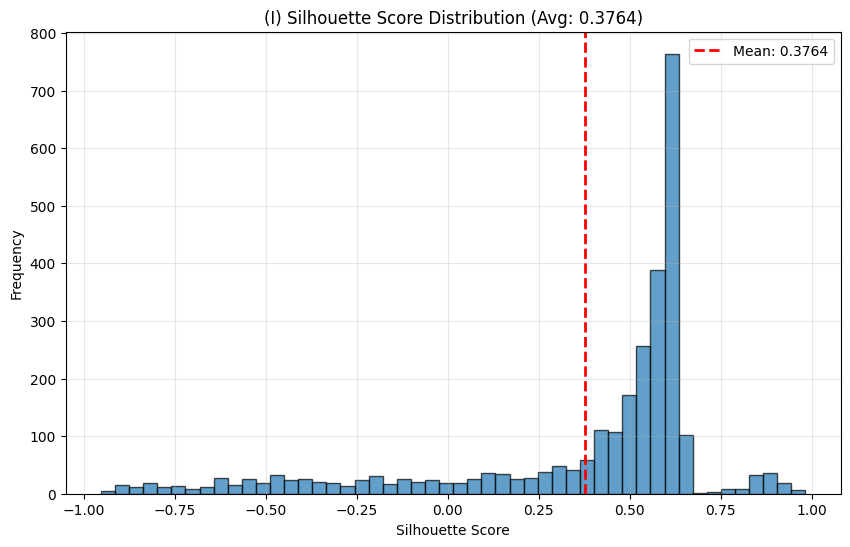


Per-Cluster Silhouette Scores:
--------------------------------------------------------------------------------
Cluster    Avg Silhouette       Quality        
--------------------------------------------------------------------------------
6          0.9769               Excellent      
8          0.9216               Excellent      
1          0.8713               Excellent      
5          0.8371               Excellent      
4          0.8255               Excellent      
7          0.7735               Excellent      
9          0.7527               Excellent      
2          0.5323               Good           
3          0.4051               Fair           
0          0.3532               Fair           



In [293]:
def compute_silhouette_score(X, labels):
    """
    Compute Silhouette score for clustering quality assessment.
    """
    unique_labels = np.unique(labels)
    valid_labels = unique_labels[unique_labels >= 0]
    
    if len(valid_labels) < 2:
        print("Cannot compute Silhouette score: need at least 2 clusters")
        return None
    
    mask = labels >= 0
    X_clustered = X[mask]
    labels_clustered = labels[mask]
    
    n_samples = len(X_clustered)
    silhouette_scores = np.zeros(n_samples)
    
    print(f"Computing Silhouette scores for {n_samples} points...")
    
    for i in range(n_samples):
        if i % 500 == 0:
            print(f"  Progress: {i}/{n_samples}")
        
        point = X_clustered[i]
        cluster_label = labels_clustered[i]
        
        same_cluster_mask = labels_clustered == cluster_label
        same_cluster_points = X_clustered[same_cluster_mask]
        
        if len(same_cluster_points) == 1:
            silhouette_scores[i] = 0
            continue
        
        a_i = np.mean([np.sqrt(np.sum((point - other)**2)) 
                       for j, other in enumerate(same_cluster_points) 
                       if not np.array_equal(point, other)])
        
        b_i = np.inf
        for other_label in valid_labels:
            if other_label == cluster_label:
                continue
            
            other_cluster_mask = labels_clustered == other_label
            other_cluster_points = X_clustered[other_cluster_mask]
            
            if len(other_cluster_points) > 0:
                avg_dist = np.mean([np.sqrt(np.sum((point - other)**2)) 
                                   for other in other_cluster_points])
                b_i = min(b_i, avg_dist)
        
        if b_i == np.inf:
            silhouette_scores[i] = 0
        else:
            silhouette_scores[i] = (b_i - a_i) / max(a_i, b_i)
    
    return silhouette_scores

silhouette_scores = compute_silhouette_score(X, final_labels)

if silhouette_scores is not None:
    avg_silhouette = np.mean(silhouette_scores)
    
    print(f"\n{'Silhouette Score Analysis:'}")
    print("-" * 80)
    print(f"Average Silhouette Score: {avg_silhouette:.4f}")
    print(f"Min Silhouette Score: {np.min(silhouette_scores):.4f}")
    print(f"Max Silhouette Score: {np.max(silhouette_scores):.4f}")
    print(f"Std Dev: {np.std(silhouette_scores):.4f}")
    
    print("\nInterpretation:")
    if avg_silhouette > 0.7:
        quality = "Excellent"
        interpretation = "Strong cluster structure, well-separated and cohesive"
    elif avg_silhouette > 0.5:
        quality = "Good"
        interpretation = "Reasonable cluster structure with some overlap"
    elif avg_silhouette > 0.25:
        quality = "Fair"
        interpretation = "Weak cluster structure, significant overlap"
    else:
        quality = "Poor"
        interpretation = "Clusters may be artificial or poorly defined"
    
    print(f"Cluster Quality: {quality}")
    print(f"Meaning: {interpretation}")
    
    plt.figure(figsize=(10, 6))
    plt.hist(silhouette_scores, bins=50, edgecolor='black', alpha=0.7)
    plt.axvline(avg_silhouette, color='r', linestyle='--', linewidth=2, label=f'Mean: {avg_silhouette:.4f}')
    plt.xlabel('Silhouette Score')
    plt.ylabel('Frequency')
    plt.title(f'(I) Silhouette Score Distribution (Avg: {avg_silhouette:.4f})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(PLOTSDIR + '1i_silhouette_distribution.png', dpi=100, bbox_inches='tight')
    plt.show()
    
    per_cluster_silhouette = {}
    mask = final_labels >= 0
    labels_clustered = final_labels[mask]
    for lab in np.unique(labels_clustered):
        cluster_mask = labels_clustered == lab
        cluster_scores = silhouette_scores[cluster_mask]
        per_cluster_silhouette[lab] = np.mean(cluster_scores)
    
    print("\nPer-Cluster Silhouette Scores:")
    print("-" * 80)
    sorted_clusters = sorted(per_cluster_silhouette.items(), key=lambda x: x[1], reverse=True)
    print(f"{'Cluster':<10} {'Avg Silhouette':<20} {'Quality':<15}")
    print("-" * 80)
    for lab, score in sorted_clusters[:10]:
        quality_label = "Excellent" if score > 0.7 else "Good" if score > 0.5 else "Fair" if score > 0.25 else "Poor"
        print(f"{lab:<10} {score:<20.4f} {quality_label:<15}")

print("\n" + "=" * 80)